In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 65
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import statistics
import math
import warnings
import itertools
from statsmodels.tsa.api import Holt
from scipy.optimize import curve_fit
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
def CI_PI_regression(xdata, yval, x1, a): #多變數的
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5

    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    
    CI = [lower_bound, upper_bound]
    PI = [lower_bound2, upper_bound2]
    return CI, PI

In [3]:
def objective(x, a, b, c):
    return a * x + b * x**2 + c
def scatter_plot(x, y, data):
    y_var = data[y].values
    for i, aname in enumerate(x):
        x_var = data[aname].values
        _ = sns.regplot(x = x_var, y = y_var, color = 'b', ci = None)
        plt.title('Scatter Plot for '+y +' and ' +aname)
        plt.ylabel(y)
        plt.xlabel(aname)
        plt.show()
def scatter_plot_2nd(x, y, data):
    y_var = data[y].values
    color = ['r', 'b', 'g', 'c', 'm', 'y']
    for i, aname in enumerate(x):
        x_var = data[aname].values
        popt, _ = curve_fit(objective, x_var, y_var)
        a, b, c = popt
        print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
        plt.scatter(x_var, y_var, color = color[i], label=aname)
        x_line = np.arange(min(x_var), max(x_var), 0.1)
        y_line = objective(x_line, a, b, c)
        plt.plot(x_line, y_line, '--', color=color[i])
    plt.ylabel(y)
    plt.legend()
    plt.show()
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()
    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []
        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]
        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)
        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected
        candidates = set(candidates) - set(selected)
        candidates = list(candidates)
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary()) 
    return result6b

# First order 和second order

,Time,Day
0,40,1
1,41,2
2,36,3
3,38,4
4,33,5


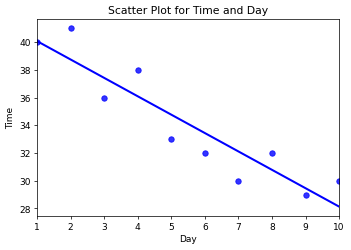

According to the scatter plot, it seems to be a linear relationship between Day and Time.


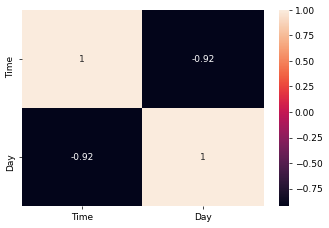

In [11]:
df18_5 = pd.read_excel("Xr18-05.xlsx")
display(df18_5.head())
scatter_plot(["Day"], "Time", df18_5)
corr5b = df18_5.corr()
_ = sns.heatmap(corr5b, annot=True)
print("According to the scatter plot, it seems to be a linear relationship between Day and Time.")
df18_5_result1 = smf.ols('Time~ Day', data=df18_5).fit()
#print(df18_5_result1.summary())
b1_1 = df18_5_result1.params[1]
b0_1 = df18_5_result1.params[0]
#print("Estimated model: y = %0.4f + %0.4f x" % (b0_1, b1_1))

,Time,Day,Day2
0,40,1,1
1,41,2,4
2,36,3,9
3,38,4,16
4,33,5,25


y = -2.49394 * x + 0.10606 * x^2 + 43.73333


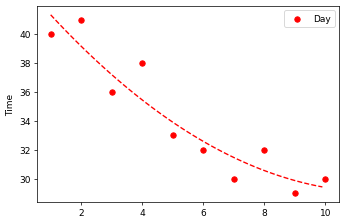

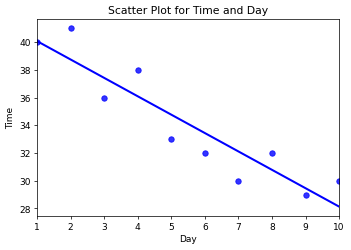

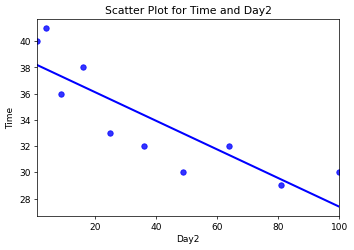

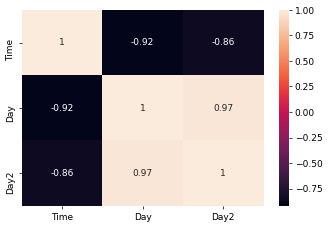

In [12]:
#second
df18_5['Day2'] = df18_5['Day'] ** 2
display(df18_5.head())
scatter_plot_2nd(["Day"], "Time", df18_5)
scatter_plot(df18_5.columns[1:], "Time", df18_5)
corr5b = df18_5.corr()
_ = sns.heatmap(corr5b, annot=True)

In [13]:
y_data = df18_5['Time']
X_data_ar = np.array([df18_5['Day'], df18_5['Day2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_5.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_5_result2 = olsmod.fit()
print(df18_5_result2.summary())

b2_2 = df18_5_result2.params[2]
b1_2 = df18_5_result2.params[1]
b0_2 = df18_5_result2.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x + %0.4f x2" % (b0_2, b1_2, b2_2))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     26.98
Date:                Mon, 30 May 2022   Prob (F-statistic):           0.000513
Time:                        00:55:19   Log-Likelihood:                -17.560
No. Observations:                  10   AIC:                             41.12
Df Residuals:                       7   BIC:                             42.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.7333      1.969     22.208      0.0

,Time,Day,Day2
0,40,-4.5,20.25
1,41,-3.5,12.25
2,36,-2.5,6.25
3,38,-1.5,2.25
4,33,-0.5,0.25


y = -1.32727 * x + 0.10606 * x^2 + 33.22500


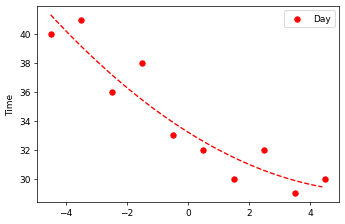

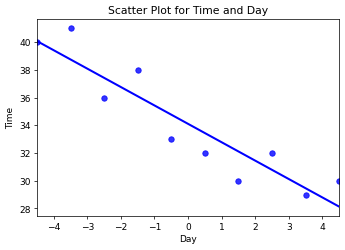

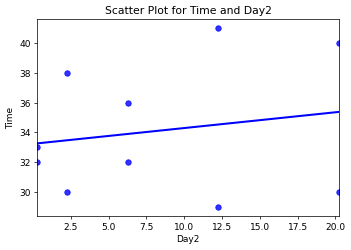

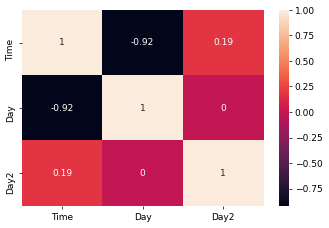

In [14]:
#Since there is issue of multicollinearity, we modify the original predictor variables by day = day - mean(day)
df18_5['Day'] = df18_5['Day']-df18_5['Day'].mean()
df18_5['Day2'] = df18_5['Day'] ** 2
display(df18_5.head())
scatter_plot_2nd(["Day"], "Time", df18_5)
scatter_plot(df18_5.columns[1:], "Time", df18_5)

corr5b = df18_5.corr()
_ = sns.heatmap(corr5b, annot=True)

In [15]:
y_data = df18_5['Time']
X_data_ar = np.array([df18_5['Day'], df18_5['Day2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_5.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_5_result2 = olsmod.fit()
print(df18_5_result2.summary())

b2_2 = df18_5_result2.params[2]
b1_2 = df18_5_result2.params[1]
b0_2 = df18_5_result2.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x + %0.4f x2" % (b0_2, b1_2, b2_2))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     26.98
Date:                Mon, 30 May 2022   Prob (F-statistic):           0.000513
Time:                        00:56:03   Log-Likelihood:                -17.560
No. Observations:                  10   AIC:                             41.12
Df Residuals:                       7   BIC:                             42.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2250      0.801     41.475      0.0

## add indicator variable

In [16]:
df18_19 = pd.read_excel("Xr17-12.xlsx")
print('Dataset(head):')
display(df18_19.head())
corr19_a = df18_19.corr()

Dataset(head):


,Time,Boxes,Weight,Codes
0,62,126,36.05,3
1,77,154,22.94,2
2,39,96,24.86,3
3,52,127,30.54,1
4,79,151,35.57,2


In [18]:
y_data = df18_19['Time']
X_data_ar = np.array([df18_19['Boxes'], df18_19['Weight'], df18_19['Codes']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_19.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_19_result1 = olsmod.fit()
print(df18_19_result1.summary())
b3 = df18_19_result1.params[3]
b2 = df18_19_result1.params[2]
b1 = df18_19_result1.params[1]
b0 = df18_19_result1.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0, b1, b2, b3))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     88.64
Date:                Mon, 30 May 2022   Prob (F-statistic):           3.87e-19
Time:                        01:05:56   Log-Likelihood:                -160.48
No. Observations:                  50   AIC:                             329.0
Df Residuals:                      46   BIC:                             336.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.4221      7.000     -5.917      0.0

Dataset(head):


,Time,Boxes,Weight,Codes_1,Codes_2,Codes_3
0,62,126,36.05,0,0,1
1,77,154,22.94,0,1,0
2,39,96,24.86,0,0,1
3,52,127,30.54,1,0,0
4,79,151,35.57,0,1,0


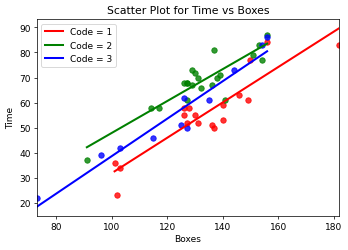

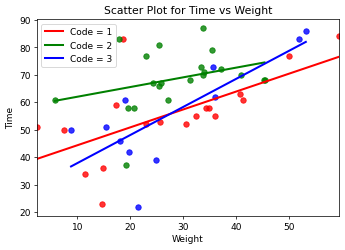

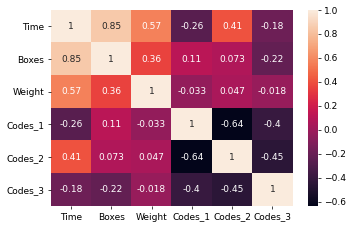

In [20]:
df18_19_dummy = pd.get_dummies(df18_19, columns = ["Codes"])
print('Dataset(head):')
display(df18_19_dummy.head())
df18_19_c1 = df18_19_dummy[df18_19_dummy.Codes_1== 1]
df18_19_c2 = df18_19_dummy[df18_19_dummy.Codes_2== 1]
df18_19_c3 = df18_19_dummy[df18_19_dummy.Codes_3== 1]

for xname in df18_19.columns[1:3]:
    _ = sns.regplot(x=xname, y= 'Time', data = df18_19_c1, color = 'r', ci = None)
    _ = sns.regplot(x=xname, y= 'Time', data = df18_19_c2, color = 'g', ci = None)
    _ = sns.regplot(x=xname, y= 'Time', data = df18_19_c3, color = 'b', ci = None)
  
    plt.legend(labels=['Code = 1', 'Code = 2', 'Code = 3'])
    plt.title('Scatter Plot for Time vs '+xname)
    plt.xlabel(xname)
    plt.ylabel('Time')
    plt.show()
    
corr19_b = df18_19_dummy.corr()
_ = sns.heatmap(corr19_b, annot=True)

In [26]:
#特別注意：三個code這邊只需要丟兩個
y_data = df18_19_dummy['Time']
X_data_ar = np.array([df18_19_dummy['Boxes'], df18_19_dummy['Weight'], df18_19_dummy['Codes_1'], df18_19_dummy['Codes_2']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df18_19_dummy.columns[1:5])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
df18_19_result2 = olsmod.fit()
print(df18_19_result2.summary())
#below is regression analysis
b4 = df18_19_result2.params[4]
b3 = df18_19_result2.params[3]
b2 = df18_19_result2.params[2]
b1 = df18_19_result2.params[1]
b0 = df18_19_result2.params[0]
print("\nEstimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3 + %0.4f x4" % (b0, b1, b2, b3,b4))

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     197.7
Date:                Mon, 30 May 2022   Prob (F-statistic):           6.31e-28
Time:                        01:23:19   Log-Likelihood:                -135.30
No. Observations:                  50   AIC:                             280.6
Df Residuals:                      45   BIC:                             290.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.7180      3.727     -7.973      0.0

H0: Beta_3 = 0<br>
H1: Beta_3 != 0<br>
Since p-value of Code_1 = 0 < alpha = 0.05, we reject H0. There is enough evidence to infer that the average time to unload **in the morning** is different from others.

# stepwise regression

,DEFINITE,DAYS1,DAYS2,DAYS3,DAYS4,DAYS5,DAYS6
0,10,0,0,0,0,0,7
1,10,0,0,3,3,0,0
2,10,3,0,1,0,2,3
3,5,3,0,5,7,1,0
4,10,7,0,3,3,4,0


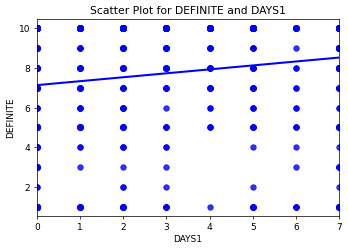

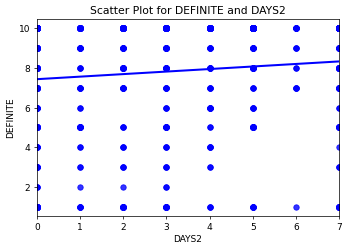

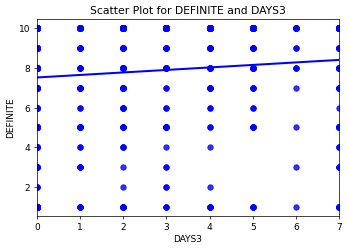

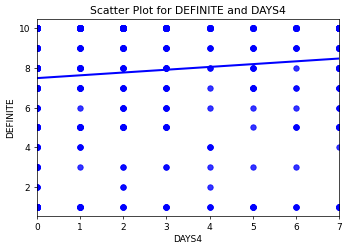

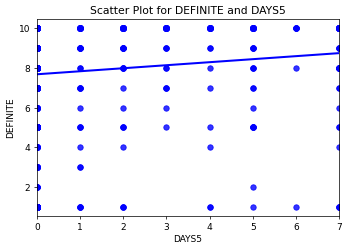

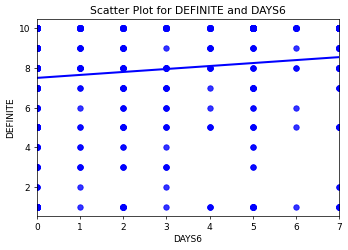

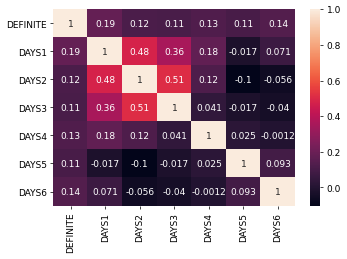

In [24]:
df18_38 = pd.read_excel("Xr17-16.xlsx")
display(df18_38.head())
scatter_plot(df18_38.columns[1:], "DEFINITE", df18_38)
corr38 = df18_38.corr()
_ = sns.heatmap(corr38, annot=True)

In [25]:
df18_38_result = forward_selection(input_df = df18_38, depv = 'DEFINITE', indepv = df18_38.columns[1:])
#怎麼換欄位
#columns_titles = ["B","A"]
#df=df.reindex(columns=columns_titles)

Current Candidates:  Index(['DAYS1', 'DAYS2', 'DAYS3', 'DAYS4', 'DAYS5', 'DAYS6'], dtype='object')
Current best model:  ['DAYS1']
Current best AdjR2:  0.0335726177176392
Current Candidates:  ['DAYS6', 'DAYS3', 'DAYS4', 'DAYS5', 'DAYS2']
Current best model:  ['DAYS1', 'DAYS6']
Current best AdjR2:  0.04760823822379723
Current Candidates:  ['DAYS4', 'DAYS3', 'DAYS5', 'DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4']
Current best AdjR2:  0.056642285730147734
Current Candidates:  ['DAYS3', 'DAYS5', 'DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5']
Current best AdjR2:  0.06483946084093561
Current Candidates:  ['DAYS3', 'DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3']
Current best AdjR2:  0.0676651778452596
Current Candidates:  ['DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3', 'DAYS2']
Current best AdjR2:  0.06730270416755912
best_adjr2 =  0.0676651778452596
best_subset =  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS

In [ ]:
b5 = df18_38_result.params[5]
b4 = df18_38_result.params[4]
b3 = df18_38_result.params[3]
b2 = df18_38_result.params[2]
b1 = df18_38_result.params[1]
b0 = df18_38_result.params[0]
print("Estimated model: y = %0.4f + %0.4f DAYS1 + %0.4f DAY6 + %0.4f DAY4 + %0.4f DAY5 + %0.4f DAY3" % (b0, b1, b2, b3, b4, b5))